In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

In [36]:
data = pd.read_csv('/Users/pranavsingh/Desktop/Finance Project/CAD_HUF Historical Data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
df = data

In [37]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-04-21,255.92,257.57,257.59,255.28,NaN,-0.69%
2025-04-20,257.69,258.35,258.44,257.55,NaN,-0.25%
2025-04-18,258.33,259.60,259.77,257.78,NaN,-0.37%
2025-04-17,259.28,258.00,260.20,257.71,NaN,0.58%
2025-04-16,257.78,259.15,259.38,257.22,NaN,-0.49%


In [ ]:
df.reset_index(inplace=True)


In [39]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2025-04-21,255.92,257.57,257.59,255.28,NaN,-0.69%
1,2025-04-20,257.69,258.35,258.44,257.55,NaN,-0.25%
2,2025-04-18,258.33,259.60,259.77,257.78,NaN,-0.37%
3,2025-04-17,259.28,258.00,260.20,257.71,NaN,0.58%
4,2025-04-16,257.78,259.15,259.38,257.22,NaN,-0.49%


In [40]:
df['Change %'] = df['Change %'].str.rstrip('%').astype(float)
df.reset_index(drop=True, inplace=True)
df['Close'] = df['Price']

for i in range(1, len(df)):
    df.loc[i, 'Close'] = df.loc[i-1, 'Close'] * (1 + df.loc[i, 'Change %'] / 100)

In [41]:
df.drop('Vol.', axis = 1, inplace=True)

In [42]:
df.drop('Change %', axis = 1, inplace=True)

In [43]:
df.head()

,Date,Price,Open,High,Low,Close
0,2025-04-21,255.92,257.57,257.59,255.28,255.920000
1,2025-04-20,257.69,258.35,258.44,257.55,255.280200
2,2025-04-18,258.33,259.60,259.77,257.78,254.335663
3,2025-04-17,259.28,258.00,260.20,257.71,255.810810
4,2025-04-16,257.78,259.15,259.38,257.22,254.557337


In [44]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)


In [45]:
df.head()

,Price,Open,High,Low,Close
Date,,,,,
2006-04-21,187.60,187.41,187.60,187.41,347.578229
2006-04-24,186.27,186.11,186.27,186.11,351.053660
2006-04-25,187.88,187.45,187.88,187.45,353.563965
2006-04-26,188.93,188.67,188.93,188.67,350.549241
2006-04-27,187.66,187.09,187.66,187.09,348.597097


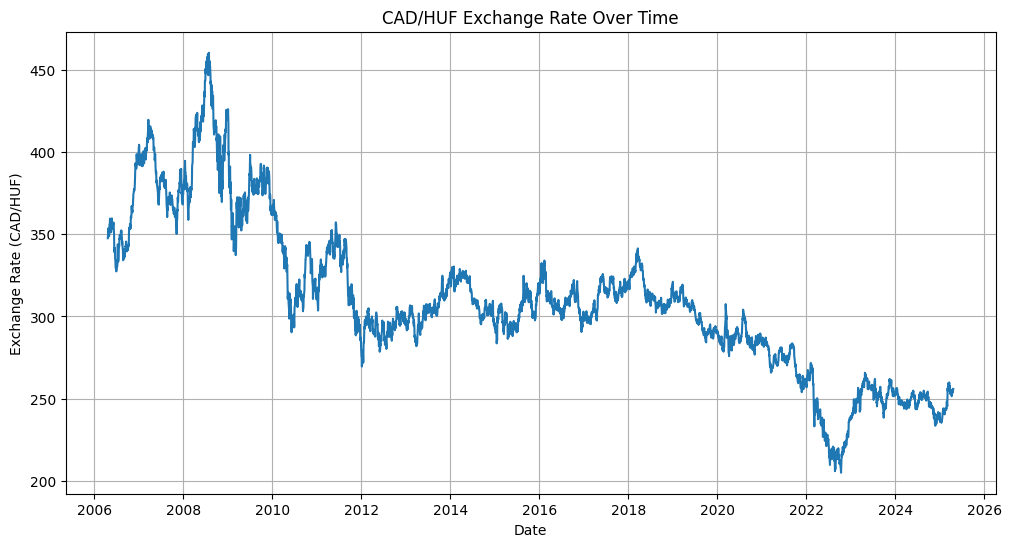

In [139]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'])
plt.title('CAD/HUF Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (CAD/HUF)')
plt.grid(True)
plt.show()


In [140]:
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

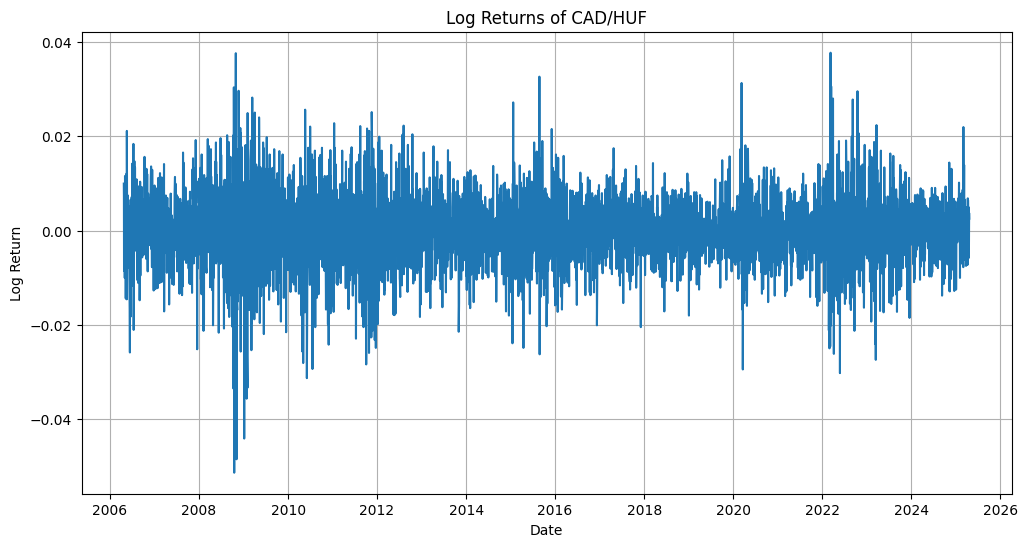

In [141]:
plt.figure(figsize=(12,6))
plt.plot(df['Log_Returns'])
plt.title('Log Returns of CAD/HUF')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()


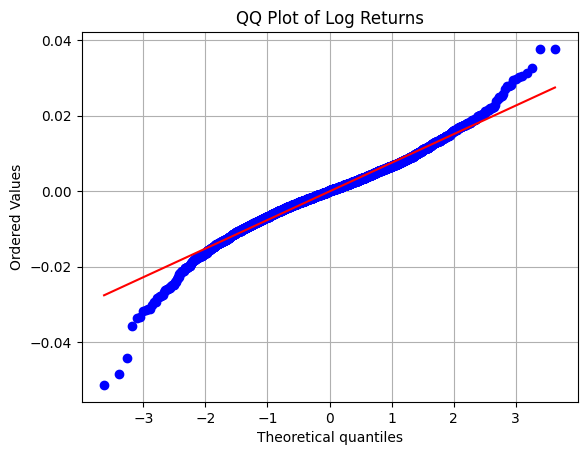

In [142]:
stats.probplot(df['Log_Returns'], dist="norm", plot=plt)
plt.title('QQ Plot of Log Returns')
plt.grid(True)
plt.show()


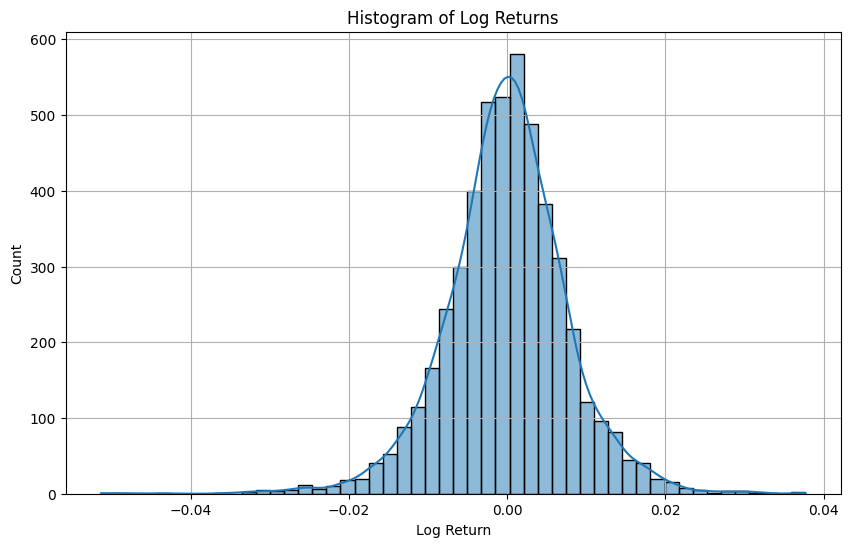

In [143]:
plt.figure(figsize=(10,6))
sns.histplot(df['Log_Returns'], kde=True, bins=50)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.grid(True)
plt.show()


In [144]:
print("Jarque-Bera Test:", stats.jarque_bera(df['Log_Returns']))
print("Kolmogorov-Smirnov Test:", stats.kstest(df['Log_Returns'], 'norm', args=(df['Log_Returns'].mean(), df['Log_Returns'].std())))
print("Anderson-Darling Test:", stats.anderson(df['Log_Returns'], dist='norm'))


Jarque-Bera Test: SignificanceResult(statistic=np.float64(1223.4322180653826), pvalue=np.float64(2.1630639322035544e-266))
Kolmogorov-Smirnov Test: KstestResult(statistic=np.float64(0.044106747314401534), pvalue=np.float64(8.107285712236904e-09), statistic_location=np.float64(-0.004390348301292961), statistic_sign=np.int8(-1))
Anderson-Darling Test: AndersonResult(statistic=np.float64(18.777791527585578), critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-6.175607502142678e-05), scale=np.float64(0.00765923344079824))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [145]:
daily_vol = df['Log_Returns'].std()
annual_vol = daily_vol * np.sqrt(252)

print(f"Annualized Volatility: {annual_vol:.4f}")


Annualized Volatility: 0.1216


In [146]:
lb_test = acorr_ljungbox(df['Log_Returns'], lags=[10], return_df=True)
print("Ljung-Box Test (Lag 10):")
print(lb_test)

Ljung-Box Test (Lag 10):
      lb_stat  lb_pvalue
10  11.896611   0.292036


In [147]:
r_domestic = 0.045
r_foreign = 0.055

In [148]:
S = df['Close'].iloc[-1]
K = S
T = (pd.Timestamp('2025-05-31') - df.index[-1]).days / 365
sigma = annual_vol

print(f"\nSpot Price: {S:.4f}")
print(f"Strike Price (ATM): {K:.4f}")
print(f"Time to Maturity (years): {T:.4f}")
print(f"Volatility (σ): {sigma:.4f}")



Spot Price: 255.9200
Strike Price (ATM): 255.9200
Time to Maturity (years): 0.1096
Volatility (σ): 0.1216


In [149]:
from scipy.stats import norm
d1 = (np.log(S/K) + (r_domestic - r_foreign + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

call_price_bs = S * np.exp(-r_foreign * T) * norm.cdf(d1) - K * np.exp(-r_domestic * T) * norm.cdf(d2)
put_price_bs = K * np.exp(-r_domestic * T) * norm.cdf(-d2) - S * np.exp(-r_foreign * T) * norm.cdf(-d1)

print(f"\nBlack-Scholes Call Option Price: {call_price_bs:.4f}")
print(f"Black-Scholes Put Option Price: {put_price_bs:.4f}")


Black-Scholes Call Option Price: 3.9488
Black-Scholes Put Option Price: 4.2277


In [150]:
def crr_binomial_fx(S, K, T, r_domestic, r_foreign, sigma, steps=500, option_type='call'):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r_domestic - r_foreign) * dt) - d) / (u - d)

    prices = S * (u ** np.arange(steps, -1, -1)) * (d ** np.arange(0, steps+1, 1))

    if option_type == 'call':
        payoffs = np.maximum(prices - K, 0)
    else:
        payoffs = np.maximum(K - prices, 0)

    for _ in range(steps):
        payoffs = np.exp(-r_domestic * dt) * (p * payoffs[:-1] + (1-p) * payoffs[1:])

    return payoffs[0]

call_price_crr = crr_binomial_fx(S, K, T, r_domestic, r_foreign, sigma, steps=500, option_type='call')
put_price_crr = crr_binomial_fx(S, K, T, r_domestic, r_foreign, sigma, steps=500, option_type='put')

print(f"\nCRR Binomial Call Option Price: {call_price_crr:.4f}")
print(f"CRR Binomial Put Option Price: {put_price_crr:.4f}")


CRR Binomial Call Option Price: 3.9467
CRR Binomial Put Option Price: 4.2257


In [151]:
def monte_carlo_fx(S, K, T, r_domestic, r_foreign, sigma, n_simulations=10000, option_type='call'):
    np.random.seed(42)
    Z = np.random.standard_normal(n_simulations)
    ST = S * np.exp((r_domestic - r_foreign - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)

    discounted_payoff = np.exp(-r_domestic * T) * np.mean(payoffs)
    return discounted_payoff

call_price_mc = monte_carlo_fx(S, K, T, r_domestic, r_foreign, sigma, n_simulations=10000, option_type='call')
put_price_mc = monte_carlo_fx(S, K, T, r_domestic, r_foreign, sigma, n_simulations=10000, option_type='put')

print(f"\nMonte Carlo Call Option Price: {call_price_mc:.4f}")
print(f"Monte Carlo Put Option Price: {put_price_mc:.4f}")


Monte Carlo Call Option Price: 3.9473
Monte Carlo Put Option Price: 4.2467


In [152]:
comparison = pd.DataFrame({
    'Method': ['Black-Scholes', 'CRR Binomial', 'Monte Carlo'],
    'Call Price': [call_price_bs, call_price_crr, call_price_mc],
    'Put Price': [put_price_bs, put_price_crr, put_price_mc]
})

print("\nComparison of Option Prices by Method:")
print(comparison)


Comparison of Option Prices by Method:
          Method  Call Price  Put Price
0  Black-Scholes    3.948767   4.227695
1   CRR Binomial    3.946723   4.225651
2    Monte Carlo    3.947293   4.246676


In [153]:
garch_model = arch_model(df['Log_Returns'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

print("\nGARCH(1,1) Model Summary:")
print(garch_result.summary())

vol_forecast = garch_result.forecast(horizon=1)
predicted_vol = np.sqrt(vol_forecast.variance.values[-1,0])

print(f"\nPredicted Volatility from GARCH: {predicted_vol:.4f}")



GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                17534.2
Distribution:                  Normal   AIC:                          -35060.3
Method:            Maximum Likelihood   BIC:                          -35034.3
                                        No. Observations:                 4957
Date:                Mon, Apr 21 2025   Df Residuals:                     4956
Time:                        19:28:53   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -6.1756e-05

/Users/pranavsingh/Desktop/Finance Project/venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.865e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/pranavsingh/Desktop/Finance Project/venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [154]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
returns_scaled = scaler.fit_transform(df['Log_Returns'].values.reshape(-1,1))

n_steps = 10
X = []
y = []
for i in range(n_steps, len(returns_scaled)):
    X.append(returns_scaled[i-n_steps:i, 0])
    y.append(returns_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='tanh', input_shape=(X.shape[1], 1)))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X, y, epochs=20, batch_size=32, verbose=1)


Epoch 1/20


/Users/pranavsingh/Desktop/Finance Project/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0330
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0296
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0303
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0296
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0320


In [156]:
from arch import arch_model

# GARCH(1,1) Model Fit
garch_model = arch_model(df['Log_Returns'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Forecast variance for the next 30 days
garch_forecast = garch_result.forecast(horizon=30)
predicted_garch_vol = np.sqrt(garch_forecast.variance.values[-1])


/Users/pranavsingh/Desktop/Finance Project/venv/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.865e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/pranavsingh/Desktop/Finance Project/venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
import numpy as np

n_simulations = 10
n_days = int(T * 252) 
simulated_prices = []

last_price = df['Close'].iloc[-1]  
last_sequence = returns_scaled[-n_steps:]  

for sim in range(n_simulations):
    prices = [last_price]
    current_sequence = last_sequence.copy()

    for day in range(n_days):
        lstm_input = current_sequence.reshape((1, n_steps, 1))
        pred_scaled_return = lstm_model.predict(lstm_input, verbose=0)
        pred_return = scaler.inverse_transform(pred_scaled_return)[0,0]

        if day < len(predicted_garch_vol):
            vol = predicted_garch_vol[day]
        else:
            vol = predicted_garch_vol[-1]

        random_shock = np.random.normal(0, vol)

        next_return = pred_return + random_shock

        next_price = prices[-1] * np.exp(next_return)
        prices.append(next_price)

        next_scaled_return = scaler.transform(np.array([[next_return]]))[0,0]
        current_sequence = np.append(current_sequence[1:], next_scaled_return)

    simulated_prices.append(prices[-1])


In [ ]:
simulated_prices = np.array(simulated_prices)

call_payoffs = np.maximum(simulated_prices - K, 0)
put_payoffs = np.maximum(K - simulated_prices, 0)

call_price_hybrid = np.exp(-r_domestic * T) * np.mean(call_payoffs)
put_price_hybrid = np.exp(-r_domestic * T) * np.mean(put_payoffs)

print(f"\nHybrid LSTM-GARCH Monte Carlo Call Option Price: {call_price_hybrid:.4f}")
print(f"Hybrid LSTM-GARCH Monte Carlo Put Option Price: {put_price_hybrid:.4f}")



Hybrid LSTM-GARCH Monte Carlo Call Option Price: 2.4938
Hybrid LSTM-GARCH Monte Carlo Put Option Price: 5.0619
